# E-commerce — Анализ товарного ассортимента

## Материалы

[Презентация](https://docs.google.com/presentation/d/1_10B8yOrLyYag0A-_JhzTrF7_laM3HJaGtUjmY3fIe8/edit?usp=sharing)

## Цель исследования

Менеджер проекта, ответственный за ассортимент интернет-магазина товаров для дома и быта «Пока
все ещё тут», поставил задачу проанализирвать продажи и дать рекомендации для:
- оптимизации асортимента, 
- увеличения выручки.

## Знакомство с данными

### Загрузка библиотек

In [1]:
import pandas as pd
import numpy as np

import scipy.stats as stats
from scipy import stats as st
import math as mth

import matplotlib.pyplot as plt 
import seaborn as sns

from pymystem3 import Mystem
m = Mystem()
from collections import Counter

import re

pd.options.display.max_colwidth = 100

import warnings
warnings.simplefilter("ignore")

### Загрузка данных

In [2]:
df = pd.read_csv('/datasets/ecommerce_dataset.csv')
df.shape

(6737, 6)

In [3]:
df.sample(5)

,date,customer_id,order_id,product,quantity,price
333,2018101922,6f1a9a1a-0322-46e4-a692-0f253fdcd1ce,14490,Пеларгония зональная диам. 12 см малиновая с красным полумахровая,1,150.0
4806,2019060716,db77c238-3c80-4032-9e3c-c30a43f4a650,14835,"Калибрахоа Mini Famous Double Blue фиолетовая махровая объем 0,5 л",1,90.0
5375,2019061610,1d6c8c1f-a799-4418-9af2-1ded47d7a85c,14833,Рассада Огурец Кристина ячейки по 6 шт Е6,1,120.0
2900,2019041616,0184f535-b60a-4914-a982-231e3f615206,14649,Львиный зев рассада однолетних цветов в кассете по 6 шт,1,128.0
1113,2018120517,34c0b91c-c8cc-4a47-98c6-f55cdfc287fb,69221,Корзина для белья пластмассовая 45 л угловая С299 1704006,1,697.0


### Описание данных

В нашем распоряжении таблица из 6737 строк и 6 столбцов. 

Датасет описывает транзакции интернет-магазина товаров для дома и быта «Пока все ещё тут».
- date — дата заказа;
- customer_id — идентификатор покупателя;
- order_id — идентификатор заказа;
- product — наименование товара;
- quantity — количество товара в заказе;
- price — цена товара.




## Предобработка данных

### Типы данных и пропуски

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6737 entries, 0 to 6736
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         6737 non-null   int64  
 1   customer_id  6737 non-null   object 
 2   order_id     6737 non-null   int64  
 3   product      6737 non-null   object 
 4   quantity     6737 non-null   int64  
 5   price        6737 non-null   float64
dtypes: float64(1), int64(3), object(2)
memory usage: 315.9+ KB


Пропусков не обнаружено. Типы данных нас устраивают, за исключением столбца 'date', который приведем к типу datetime:

In [5]:
df['date'] = pd.to_datetime(df['date'], format='%Y%m%d%H')
df.sample(3)

,date,customer_id,order_id,product,quantity,price
6576,2019-10-10 22:00:00,31a39955-8a93-42f3-8839-04a9693632a7,72778,Шеффлера Голд Капелла d-12 см h-25 см,1,149.0
416,2018-10-26 13:00:00,9f1e7d7d-ff10-4eb1-b596-1cbf8075aa3f,68760,"Вешалка деревянная с расширенными плечиками и перекладиной 44,5х23 см см серый JAPANESE BLACK VA...",8,262.0
6355,2019-09-18 21:00:00,a35f9963-ce9a-4cb5-b954-f1b6206ec0ac,72689,Мята перечная Тач Tachi d-7 см h-10 см мандариновая мята укорененный черенок,1,74.0


Также на всякий случай переведем номера заказов из целочисленного типа в текст, чтобы не оперировать ими как числами:

In [6]:
df['order_id'] = df['order_id'].astype('str')
df['order_id'].dtype

dtype('O')

### Дубликаты

In [7]:
df.duplicated().sum()

0

Явные дубликаты не обнаружены. Попробуем найти неявные, для этого проверим коректность присвоения номеров заказов:

Посмотрим, не используются ли у нас одинаковые номера заказов для разных покупателей:

In [8]:
orders_duplicates_1 = df.groupby('order_id').agg({'customer_id':'nunique'})\
                    .reset_index()\
                    .query('customer_id > 1')\
                    .sort_values(by='customer_id', ascending=False)

print(orders_duplicates_1.shape)
orders_duplicates_1.head()

(29, 2)


,order_id,customer_id
2610,72845,4
902,69485,3
1914,71480,3
248,14872,2
1651,70946,2


Итак, 29 номеров заказов присвоены сразу нескольким покупателям - от 2х до 4х. Проверим сколько строк, содержат повторяющиеся номера заказов:

In [9]:
wrong_orders_1 = orders_duplicates_1['order_id'].to_list()

df.query('order_id in @wrong_orders_1').shape

(89, 6)

89 записей содержат дублирующиеся номера заказов. Посмотрим, что это за записи на примере одного заказа (примечание: я проверила 5 номеров заказов):

In [10]:
df.query('order_id == "72845"')

,date,customer_id,order_id,product,quantity,price
6504,2019-10-03 14:00:00,d8465f63-35db-4809-aff3-a8f7ebfc257f,72845,Муляж Яблоко зеленый 9 см полиуретан,40,59.0
6505,2019-10-03 15:00:00,0309d37c-ab5f-4793-ba72-5484c019b840,72845,Муляж Яблоко зеленый 9 см полиуретан,40,59.0
6508,2019-10-04 08:00:00,25a8cd52-3efa-48ee-a6bd-d413d7e2b42f,72845,Муляж Яблоко зеленый 9 см полиуретан,40,59.0
6538,2019-10-07 20:00:00,2ac05362-3ca7-4d19-899c-7ba266902611,72845,Муляж Яблоко зеленый 9 см полиуретан,40,59.0


Разные даты, разные покупатели, все остальное - совпадает. Похоже на техническую ошибку при формировании / выгрузке базы данных.


Теперь проверим, не дублируются ли номера заказов для одного и того же покупателя в разные даты:

In [11]:
orders_duplicates_2 = df.groupby(['customer_id','order_id']).agg({'date':'nunique'})\
                    .reset_index()\
                    .query('date > 1')\
                    .sort_values(by='date', ascending=False)

print(orders_duplicates_2.shape)
orders_duplicates_2.head()

(265, 3)


,customer_id,order_id,date
307,1d6c8c1f-a799-4418-9af2-1ded47d7a85c,14833,74
924,57cc80a2-2610-4eef-9457-e7c3bf0c72f0,70960,60
1477,8c290149-ad54-4d7a-87a7-9386b36390ee,69162,23
1810,ae6940d3-a1c7-4997-8853-a5b8afc60d51,71148,16
1044,63b6c7b2-f6c2-4a42-ba02-1910ec67f57e,70419,10


Как видим, 265 номеров заказов дублируются для одного и того же покупателя в разные даты. Это тоже нетипичная картина. Посчитаем количество строк с проблемными номерами заказов:

In [12]:
wrong_orders_2 = orders_duplicates_2['order_id'].to_list()

df.query('order_id in @wrong_orders_2').shape

(2427, 6)

В этот раз найдено 2427 записей с дублирующимеся номерами заказов. Посмотрим на эти записи:

In [13]:
df.query('order_id == "69162"').sample(5)

,date,customer_id,order_id,product,quantity,price
1046,2018-12-01 20:00:00,8c290149-ad54-4d7a-87a7-9386b36390ee,69162,Термометр на окно уличный на липучках Т-5 h-20 см 1210035,2,44.0
1133,2018-12-08 18:00:00,8c290149-ad54-4d7a-87a7-9386b36390ee,69162,Термометр на окно уличный на липучках Т-5 h-20 см 1210035,2,44.0
1045,2018-12-01 18:00:00,8c290149-ad54-4d7a-87a7-9386b36390ee,69162,Термометр на окно уличный на липучках Т-5 h-20 см 1210035,2,44.0
1220,2018-12-16 13:00:00,8c290149-ad54-4d7a-87a7-9386b36390ee,69162,Термометр на окно уличный на липучках Т-5 h-20 см 1210035,2,44.0
1308,2018-12-22 20:00:00,8c290149-ad54-4d7a-87a7-9386b36390ee,69162,Термометр на окно уличный на липучках Т-5 h-20 см 1210035,2,44.0


Один и тот же человек покупает один и тот же товар в одинаковом количестве несколько раз с интервалом в несколько дней / часов - это на правду не похоже. Явно идет задвоение заказов.

Посчитаем дубликаты по всем столбцам кроме номера покупателя и даты:

In [14]:
df.drop(['customer_id', 'date'], axis=1).duplicated().sum()

1897

In [15]:
print('Количество неявных дубликатов: {}, что составляет {:.1%} от датасета'
      .format(df[['order_id', 'product', 'quantity', 'price']].duplicated().sum(), 
             df[['order_id', 'product', 'quantity', 'price']].duplicated().sum()/len(df)))

Количество неявных дубликатов: 1897, что составляет 28.2% от датасета


Дубликаты составляют почти треть датасета, но удалить их все же придется. Оставим при этом последние записи, как более актуальные. 

Точная причина задвоения номеров заказов нам не известна, но будем исходить из того, что после того как заказ состоялся, его номер уже не может быть присвоен другому заказу. Т.е. предположим, что предыдущие дубли - это неудачные попытки создать заказ, которые почему-то попали в базу данных как оформленные заказы.

In [16]:
df = df.drop_duplicates(subset=['order_id','product','quantity','price'], keep='last')
df.shape

(4840, 6)

### Вывод

В ходе предобработки данных мы
- преобразовали тип данных для столбца с датой и временем в datetime
- преобразовали столбец с номером заказов в текстовый тип
- удалили неявные дубликаты (28% датасета) - задвоения номеров заказов для разных покупателей и для разных дат.

В результате в датасете осталось 4840 записей.

## Исследовательский анализ данных

### Характеристики распределения показателей

Изучим общую картину продаж и поищем закономерности в данных.

#### Распределение покупок по дням

Для начала посмотрим, с каким периодом мы имеем дело и как распределяются покупки по датам (под покупкой понимаем 1 запись в базе данных):

In [17]:
date_min = df['date'].min()
date_max = df['date'].max()

print(f'Начало периода: {date_min}, окончание периода {date_max}')

Начало периода: 2018-10-01 00:00:00, окончание периода 2019-10-31 16:00:00


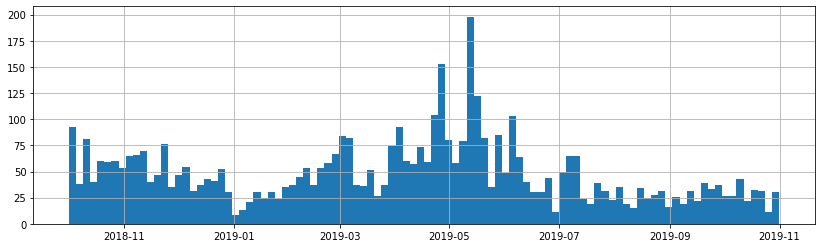

In [18]:
df.date.hist(bins=100, figsize=(14,4));

- Анализируемый период - год и один месяц - с октября 2018 по октябрь 2019 г включительно. Интересно, что количество покупок (записей датасета) в октябре 2018 выше, чем в октябре 2019.

- Продажи в нашем магазине подвержены сезонным колебаниям.

- На гистограмме наблюдаем пики в мае и июне, скорее всего, связанные с началом дачного сезона и праздничными днями. 

- Заметен спад в конце декабря-начале января, что вполне закономерно, т.к. подготовка к Новому году и закупка праздничных товаров идет обычно заранее. 

- Также есть спад в конце июня, следующий сразу после пика. Видимо, это временное затишье после массовой скупки сезонных товаров. Либо какие-то технические работы на сайте.

В целом распределение покупок по датам выглядит правдоподобно.

#### Количество покупателей

In [19]:
df['customer_id'].nunique()

2423

Наш интернет-магазин за весь период посетили 2 422 покупателя.

#### Характеристики числовых столбцов

Прежде чем выводить описание числовых столбцов, добавим столбец с выручкой, который так и напрашивается при наличии цены и количества:

In [20]:
df['revenue'] = df['price'] * df['quantity']
df.sample(3)

,date,customer_id,order_id,product,quantity,price,revenue
1058,2018-12-02 15:00:00,036118cf-c198-48fa-ba15-6d841482a56d,69176,Тарелка суповая ВОЛАРЭ БЛЭК 23 см G9402 Luminarc,3,127.0,381.0
3493,2019-05-09 15:00:00,1809d8b0-c702-450d-a73c-76fc90386411,14742,"Фуксия Dark Eyes синяя с красным чашелистом объем 0,5 л",1,112.0,112.0
2849,2019-04-14 22:00:00,6a5dc143-5814-4d37-93f3-e4414d8adc41,71142,Искусственный цветок Ландыш пластиковый большой белый,10,20.0,200.0


Теперь можем выводить общие характеристики числовых столбцов:

In [21]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
quantity,4840.0,2.815702,17.637293,1.0,1.0,1.0,1.0,1000.0
price,4840.0,514.925413,945.454941,9.0,90.0,150.0,488.0,14917.0
revenue,4840.0,850.548347,9840.403436,9.0,120.0,194.0,734.0,675000.0


- В подавляющем большинстве заказов товары покупаются по 1 шт. Однако встречаются и заказы с 1000 единиц одного наименования. У распределения пик в районе 1 шт и длинный хвост с выбросами справа.

- Цены в нашем интерент-магазине варьируются от 9 до 14 917 у.е. Но обычно товары стоят в пределах 500 у.е. Медианная цена (150) ниже средней (515), значит пик у нас слева, а хвост с выбросами - справа.

- Стоимость одной позиции в заказе  с учетом количества может составлять от 9 до 675000 у.е., чаще всего - до 700 у.е., медиана (194) ниже среднего (851), распределение также скошено вправо (имеет хвост с выбросами справа).

Оценим теперь основные показатели визуально.

#### Распределение количества одинаковых товаров в заказе

Интересно, сколько штук одного наименования покупают чаще всего:

(0.0, 30.0)

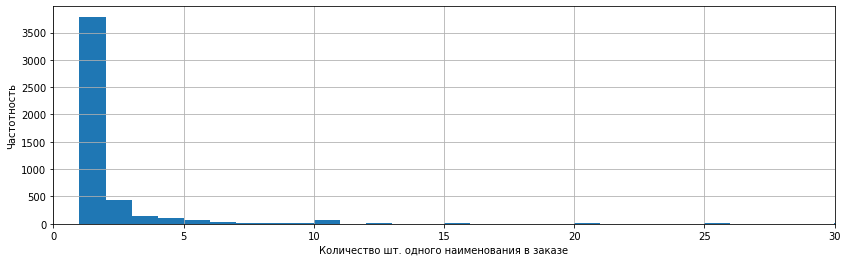

In [22]:
df.quantity.hist(bins=1000, figsize=(14,4));
plt.ylabel('Частотность')
plt.xlabel('Количество шт. одного наименования в заказе')
plt.xlim(0,30)

Обычно товары покупают по 1 шт. Иногда - по 2-10 шт. Свыше 10 шт - уже большая редкость. Посмотрим на аномальные строки датасета:

In [23]:
anomaly_quantity = df.query('quantity > 10')\
                    .sort_values(by='quantity', ascending=False)

print('Количество строк, где в заказе более 10 шт. одного наименования: {}, доля от всего датасета: {:.1%}'
      .format(len(anomaly_quantity), len(anomaly_quantity)/len(df)))

anomaly_quantity.head()

Количество строк, где в заказе более 10 шт. одного наименования: 149, доля от всего датасета: 3.1%


,date,customer_id,order_id,product,quantity,price,revenue
5456,2019-06-18 15:00:00,312e9a3e-5fca-43ff-a6a1-892d2b2d5ba6,71743,"Вантуз с деревянной ручкой d14 см красный, Burstenmann, 0522/0000",1000,675.0,675000.0
5071,2019-06-11 07:00:00,146cd9bf-a95c-4afb-915b-5f6684b17444,71668,Вешалки мягкие для деликатных вещей 3 шт шоколад,334,148.0,49432.0
3961,2019-05-20 21:00:00,5d189e88-d4d6-4eac-ab43-fa65a3c4d106,71478,Муляж ЯБЛОКО 9 см красное,300,51.0,15300.0
1158,2018-12-10 14:00:00,a984c5b7-ff7e-4647-b84e-ef0b85a2762d,69289,"Ручка-скоба РС-100 белая *Трибатрон*, 1108035",200,29.0,5800.0
568,2018-11-01 08:00:00,aa42dc38-780f-4b50-9a65-83b6fa64e766,68815,Муляж ЯБЛОКО 9 см красное,170,51.0,8670.0


Посмотрим также на "хвост" нашего среза, чтобы убедиться, что мы корректно выбрали границу аномалии. (Примечание: я пробовала устанавливать границу среза на 5 штуках, но когда вывела "хвост", поняла, что эти товары действительно покупают в таком количестве обычные люди, поэтому остановилась на 10 шт.)

In [24]:
anomaly_quantity.tail()

,date,customer_id,order_id,product,quantity,price,revenue
5978,2019-07-28 14:00:00,6b0c6cfb-7717-4c34-8535-bbc6e2b2c758,72125,Муляж Красное яблоко мини полиуретан d-5 см,11,22.0,242.0
50,2018-10-02 15:00:00,4d93d3f6-8b24-403b-a74b-f5173e40d7db,68506,"Герань домашняя (пеларгония зональная) цветущая D12, H25-30, коралловая, полумахровая",11,142.0,1562.0
3502,2019-05-09 21:00:00,f479df63-c15c-4d4e-9866-cd91b3e8bcfc,14745,Пеларгония зональная диам. 12 см красная махровая,11,188.0,2068.0
3068,2019-04-24 09:00:00,909530ce-406f-457a-8289-fc62cba16d14,71262,Цветок искусственный Гвоздика пластиковая одиночная в ассортименте 50 см,11,21.0,231.0
2373,2019-03-18 13:00:00,f454ae14-70ad-4678-b71e-0da3c1c8c6f2,70718,"Емкость для СВЧ LUX 3.2 л прямоугольная, Curver, 15552",11,265.0,2915.0


Похоже, что там, где количество товара более 10 шт. - это закупки для нужд малого бизнеса (например, гостиничного). Ну а 1000 вантузов - это либо закупка с целью перепродажи, либо ошибка. 

Всего у нас 149 строк c аномальным количеством, это 3,1% датасета. Можно было бы их удалить. Но мы не станем этого делать, удалим только 1000 вантузов (чтобы не искажали нам остальные показатели), а остальные строки пометим в отдельном столбце. И далее при анализе будем смотреть на них отдельно.

In [25]:
df = df.query('quantity < 1000')
df.shape

(4839, 7)

Сформируем список покупателей с крупными заказами и пометим все строки датасета для этих покупателей (и всех их заказов) условным обзначением 'b2b':

In [26]:
big_orders = anomaly_quantity['customer_id'].unique()

def b2b(customer_id):
    '''
    Функция принимает номер покупателя, 
    а возвращает принадлежность покупки к типу b2b:
    - True - номер покупателя в списке покупателей с крупными заказами
    - False - в противном случае
    '''
    if customer_id in big_orders:
        return True
    return False

df['b2b'] = df['customer_id'].apply(b2b)
df.sample(3)

,date,customer_id,order_id,product,quantity,price,revenue,b2b
4499,2019-06-04 17:00:00,07abcccf-1887-4b4e-b6bf-8054759bc419,71605,"Штора для ванной комнаты полиэстер Dasch 180х180 см Аквамарин ВТ-822502, 5698",1,329.0,329.0,False
300,2018-10-18 14:00:00,b371ce80-259a-4bb8-a550-0ebff690e3e1,68682,Жидкое мыло Vestar Хозяйственное 750 мл Россия 4620757212370,1,59.0,59.0,False
107,2018-10-05 12:00:00,b463177a-cc14-44f6-a225-0e03170f5d41,68536,Коврик хлопковый 45х75 см цвета в ассортименте 6195,2,127.0,254.0,False


Теперь у нас есть возможность анализировать покупки массовых покупателей и предпринимателей отдельно. Посчитаем соотношение заказов обычных потребителей и предпринимателей:

In [27]:
customer_groups = df.groupby('b2b').agg({'customer_id':'nunique', 'order_id':'nunique'})\
                    .reset_index()
customer_groups['customers_share'] = round(customer_groups['customer_id'] / customer_groups['customer_id'].sum(),2)
customer_groups['orders_share'] = round(customer_groups['order_id'] / customer_groups['order_id'].sum(),2)
customer_groups

,b2b,customer_id,order_id,customers_share,orders_share
0,False,2296,2481,0.95,0.89
1,True,126,302,0.05,0.11


95% покупателей - обычные, на их долю приходится 89% заказов.

5% покупателей - предприниматели, на их долю приходится 11% заказов. Т.е. повторные заказы у нас характерны имеено для предпринимателей.

#### Распределение цен

Посмотрим, товары какого ценового уровня продаются в нашем интернет-магазине:

(0.0, 2000.0)

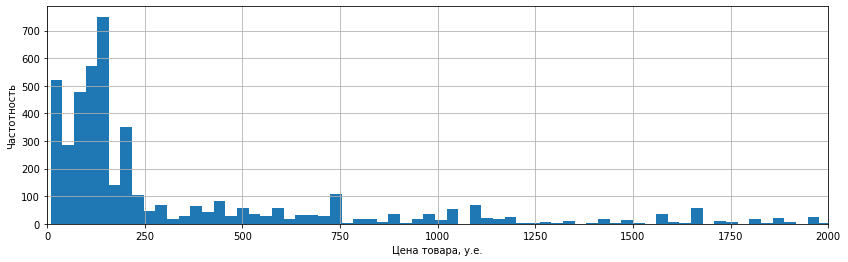

In [28]:
df.price.hist(bins=500, figsize=(14,4));
plt.ylabel('Частотность')
plt.xlabel('Цена товара, у.е.')
plt.xlim(0,2000)

В основном, цены покупаемых товаров находятся в пределах 200 у.е. Реже  цена доходит до 1200 у.е. Свыше 1200 - это уже единичные случаи. Посмотрим, сколько у нас таких редких случаев и как они выглядят в датасете:

In [29]:
high_prices = df.query('price > 1200').sort_values(by='price', ascending=False)

print('Количество строк c ценами выше 1200 у.е.: {}, доля от всего датасета: {:.1%}'
      .format(len(high_prices), len(high_prices)/len(df)))

high_prices.head(5)

Количество строк c ценами выше 1200 у.е.: 519, доля от всего датасета: 10.7%


,date,customer_id,order_id,product,quantity,price,revenue,b2b
5992,2019-07-29 17:00:00,0d87f4ae-465a-4fac-81e6-5d629761783e,72139,Сушилка уличная Leifheit 85210 LINOMATIC V 400 40 м 175х237х237 см зеленая,1,14917.0,14917.0,False
2697,2019-04-05 19:00:00,c0c60544-3a99-49d0-8a8e-cf7f293c22cb,71035,"Сумка-тележка хозяйственная Andersen Royal Shopper, Hera, синяя 166-004-90",1,8737.0,8737.0,False
1981,2019-02-24 10:00:00,ac250053-a236-467a-97d2-ddbb9bf4a1ba,70423,"Сумка-тележка хозяйственная Andersen Alu Star Shopper, Hava, синяя 115-103-90",1,8437.0,8437.0,False
2997,2019-04-21 16:00:00,19d904d8-8d16-476d-8f66-b2a3b7a23660,71227,Сумка-тележка хозяйственная Rolser MNB019 rojo LOGIC DOS+2 красная,1,8077.0,8077.0,False
6629,2019-10-16 15:00:00,d5584388-ffbe-42fd-a746-a98828ec919f,72992,Стремянка 7 ступенчатая Hailo 8040-707 XXL 13 см алюминиевая с лотком для инструментов,1,7724.0,7724.0,False


Цены реальные (я загуглила), доля таких товаров ощутимая - почти 11% датасета, исключать из анализа их не хотелось бы, поэтому просто классифицируем товары по цене и выделим дорогие товары в отдельную группу:

In [30]:
def price_level(price):
    '''
    Функция принимает цену товара, 
    а возвращает принадлежность товара к одному из типов:
    - Дорогостоящие - если цена > 1200
    - Средний ценовой сегмент - если цена > 200
    - Дешевые - если цена <= 200
    '''
    if price > 1200:
        return 'Дорогостоящие'
    if price > 200:
        return 'Средний ценовой сегмент'
    return 'Дешевые'

df['price_level'] = df['price'].apply(price_level)
df.sample(3)

,date,customer_id,order_id,product,quantity,price,revenue,b2b,price_level
2741,2019-04-08 14:00:00,35fe171f-0ce0-4c9e-9c32-10be72f17792,14626,Петуния простая рассада однолетних цветов в кассете по 10 шт,1,210.0,210.0,False,Средний ценовой сегмент
1718,2019-02-06 12:00:00,62952c5b-e5ef-4009-a2f9-1ebff401c514,14532,Пеларгония зональная махровая белая взрослое растение,1,150.0,150.0,False,Дешевые
3515,2019-05-11 08:00:00,240622a9-246f-46e8-b356-4be471d112d4,71396,Ковер придверный Tango RUS 60х90 см белый РВ322,1,599.0,599.0,False,Средний ценовой сегмент


Итак, мы получили представления о ценах и заодно разделили наш ассортимент по ценовым сегментам.

Посчитаем, сколько у нас всего наименований товаров и какую долю занимают ценовые сегменты:

In [31]:
df['product'].nunique()

2342

Всего у нас представлено 2342 наименования товаров.

In [32]:
price_levels = df.groupby('price_level').agg({'product':'nunique'})\
                    .reset_index()\
                    .sort_values(by='product', ascending=False)
price_levels.columns = ['price_level', 'product_names_count']
price_levels['share'] = round(price_levels['product_names_count'] / price_levels['product_names_count'].sum(),2)
price_levels

,price_level,product_names_count,share
0,Дешевые,1258,0.53
2,Средний ценовой сегмент,765,0.32
1,Дорогостоящие,331,0.14


53% ассортимента (по количеству наименований) составляют дешевые товары стоимостью до 200 у.е. 14% - дорогостоящие товары стоимостью свыше 1200 у.е.

#### Распределение стоимости заказов

Проверим также, как распределена стоимость заказов, нет ли там аномалий - сверхкрупных разовых заказов, искажающих динамику. Для этого сначала сгруппируем данные по номеру заказа, рассчитаем стоимость каждого заказа, а затем построим распределение:

In [33]:
orders_sum = df.groupby('order_id').agg({'revenue':'sum'}).reset_index()
orders_sum.columns=['order_id', 'order_sum']
orders_sum.head()

,order_id,order_sum
0,12624,375.0
1,13547,684.0
2,14480,359.0
3,14481,600.0
4,14482,376.0


In [34]:
orders_sum.describe().T

,count,mean,std,min,25%,50%,75%,max
order_sum,2783.0,1236.670499,2231.953313,14.0,291.5,688.0,1466.0,49432.0


(0.0, 20000.0)

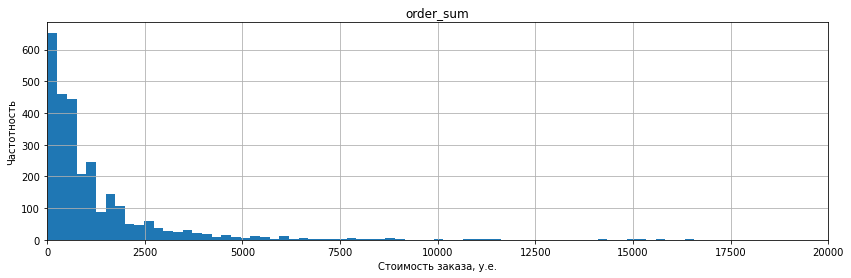

In [35]:
orders_sum.hist(bins=200, figsize=(14,4));
plt.ylabel('Частотность')
plt.xlabel('Стоимость заказа, у.е.')
plt.xlim(0,20000)

Всего у нас за исследуемый период оформлено 2783 заказа, стоимость заказов варьируется от 14 до почти 50 000 у.е. Средняя стоимость заказа - 1236 у.е., медианная - 688 у.е.

Здесь мы не делим заказы на массовых покупателей и предпринимателей, потому что наша цель -  выявить только особо крупные заказы, которые могут исказить картину выручки и помешать анализировать сезонность.

Распространенной является стоимость заказа до 5 000 у.е. Где-то до 9 000 у.е. заказы продолжают встречаться, но уже редко. Далее гистограмма начинает прерываться, значит пошли выбросы.

Посмотрим на выбросы:

In [36]:
large_orders = orders_sum.query('order_sum > 9000').sort_values(by='order_sum', ascending=False)
large_orders.head()

,order_id,order_sum
2008,71668,49432.0
1065,69830,47385.0
722,69156,33680.0
917,69504,32718.0
569,68878,24370.0


In [37]:
large_orders.tail()

,order_id,order_sum
1105,69928,11250.0
1214,70135,11000.0
152,14735,10656.0
705,69127,9915.0
482,68727,9010.0


In [38]:
large_orders_list = large_orders['order_id'].to_list()
print('Количество крупных заказов:', len(large_orders_list))

df.query('order_id == "69127"')

Количество крупных заказов: 18


,date,customer_id,order_id,product,quantity,price,revenue,b2b,price_level
999,2018-11-27 15:00:00,7d8528bb-623e-477f-a059-efc312b62d29,69127,"Вешалка деревянная с расширенными плечиками и перекладиной 44,5х23 см см белый JAPANESE WHITE VA...",12,263.0,3156.0,True,Средний ценовой сегмент
1000,2018-11-27 15:00:00,7d8528bb-623e-477f-a059-efc312b62d29,69127,Вешалка для брюк Attribute CLASSIC 38 см AHN271,10,132.0,1320.0,True,Дешевые
1001,2018-11-27 15:00:00,7d8528bb-623e-477f-a059-efc312b62d29,69127,Набор вешалок для костюма 45 см 4 шт цвет кремовый Attribute AHP224,25,202.0,5050.0,True,Средний ценовой сегмент
1002,2018-11-27 15:00:00,7d8528bb-623e-477f-a059-efc312b62d29,69127,Набор вешалок универсальных Attribute SILUET CREAM 45 см 4 шт AHP224,1,389.0,389.0,True,Средний ценовой сегмент


Итого у нас 18 крупных заказов стоимостью свыше 9000 у.е. Проверим, все ли они относятся к категории b2b, и если это так, то нет необходимости их исключать или как-то дополнительно помечать, т.к. категорию b2b мы и так будем анализировать отдельно:

In [39]:
df.query('order_id in @large_orders_list & not b2b')['order_id'].unique()

array(['68760', '68878', '70080', '14735', '71598', '72139'], dtype=object)

In [40]:
df.query('order_id == "72139"')

,date,customer_id,order_id,product,quantity,price,revenue,b2b,price_level
5992,2019-07-29 17:00:00,0d87f4ae-465a-4fac-81e6-5d629761783e,72139,Сушилка уличная Leifheit 85210 LINOMATIC V 400 40 м 175х237х237 см зеленая,1,14917.0,14917.0,False,Дорогостоящие


Из 18 крупных заказов 6 у нас отнесены к заказам обычных покупателей (остальные 12 - к заказам предпринимателей). 

В 4 из 6 крупных заказов обычных покупателей попали дорогостоящие позиции, дорогостоящие товары мы уже выдедили в отдельную категорию, поэтому при желании можем анализировать их отдельно.

Оставшиеся 2 крупных заказа обычных покупателей (14735 и 71598) содержат большое количество товаров среднего ценового сегмента (но каждая позиция не более 10 шт.): суммарно 20 разных кашпо с петуниями и 10 скатертей соответственно. Логично будет перенести эти заказы в категорию b2b, чтобы анализировать отдельно от основной массы заказов. Перепишем ранее созданную функцию, добавив в нее 2 новых заказа и заново применим к столбцу b2b:

In [41]:
big_orders_new = df.query('b2b')['order_id'].unique().tolist()
new_orders = ['14735', '71598']
big_orders_new = big_orders_new + new_orders

def b2b_new(order_id):
    '''
    Функция принимает номер заказа, 
    а возвращает принадлежность покупки к типу b2b:
    - True - номер заказа в списке крупных заказов
    - False - в противном случае
    '''
    if order_id in big_orders_new:
        return True
    return False

df['b2b'] = df['order_id'].apply(b2b_new)

In [42]:
df.query('order_id == "71598"')

,date,customer_id,order_id,product,quantity,price,revenue,b2b,price_level
4435,2019-06-04 07:00:00,940c175f-ea87-44e0-9e16-0a3d0a9abecd,71598,Скатерть круглая d-175 см 50% полиэстер 50% хлопок белая Wellness MLd-187-Эстель*01,10,1140.0,11400.0,True,Средний ценовой сегмент


Теперь мы знаем, что крупные заказы у нас - это либо заказы для бизнеса, либо покупки дорогостоящих товаров. Заказы для бизнеса у нас помечены, дорогостоящие товары тоже выделены в отдельную категорию, так что при анализе мы можем их отделять от остальных данных.

### Динамика агрегированных показателей

#### Выручка по месяцам

Хотелось бы посмотреть на выручку от продаж по месяцам. Для этого выделим месяц в отдельный столбец. Помним, что у нас два октября, поэтому выведем в новый столбец не номер/название месяца, а первое число месяца с указанием года:

In [43]:
df['month'] = df['date'].astype('datetime64[M]')
df.sample(3)

,date,customer_id,order_id,product,quantity,price,revenue,b2b,price_level,month
360,2018-10-22 13:00:00,e1443c41-ef4c-4749-a67e-cb94ecfcdcb9,68716,"Сушилка для белья потолочная Лиана 2,4 м 1703011",1,734.0,734.0,False,Средний ценовой сегмент,2018-10-01
5227,2019-06-13 14:00:00,891f87e2-0077-42b1-b350-5361115ef7c0,71697,Тележка багажная DELTA ТБР-20 коричневый с оранжевым грузоподъемность 25 кг сумка и 50 кг каркас...,1,734.0,734.0,False,Средний ценовой сегмент,2019-06-01
3315,2019-04-29 15:00:00,cce13789-408b-44e1-8147-3c74dc393bf1,14701,Тагетис крупноцветковый рассада однолетних цветов в кассете по 10 шт,2,210.0,420.0,False,Средний ценовой сегмент,2019-04-01


Теперь рассчитаем выручку за каждый месяц и построим диаграмму:

In [44]:
def dynamic(feature, func, header):
    '''
    Функция принимает название показателя (колонки) датафрейма,
    название агрегирующей функции и заголовок,   
    затем строит сводную таблицу этого показателя по месяцам
    и возвращает диаграмму с областями
    '''
    pivot = df.pivot_table(index='month', columns='b2b', values=feature, aggfunc=func)
    
    pivot.plot(figsize=(14,4), title=header, 
               grid=True, style='-o', stacked=True, kind='area')
    plt.legend(['Обычные потребители','Предприниматели'])
    plt.show()

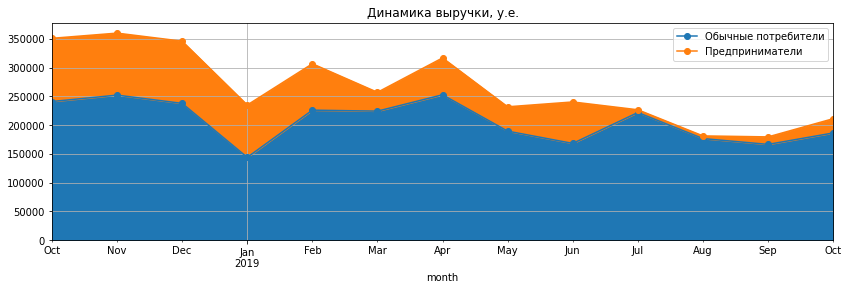

In [45]:
dynamic('revenue', 'sum', 'Динамика выручки, у.е.')

Судя по графику, выручка падает, и это плохая новость. Причем падение идет за счет сегмента предпринимателей (b2b). Соответственно, наша задача - выручку увеличивать, но сначала нужно найти причину падения. 

Выручка зависит от количества покупателей, количества заказов и среднего чека, посчитаем эти показатели далее.

#### Количество покупателей по месяцам

Посчитаем количество покупателей за каждый месяц и построим график:

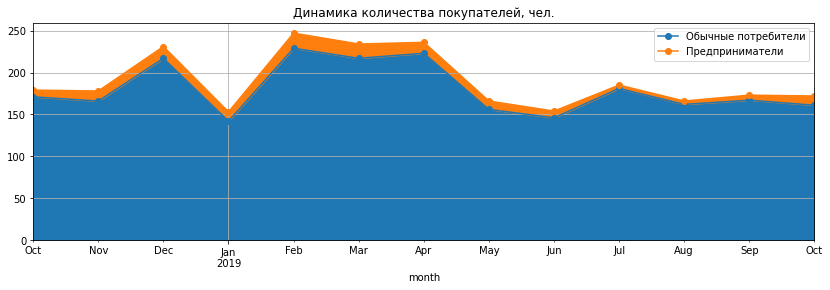

In [46]:
dynamic('customer_id', 'nunique', 'Динамика количества покупателей, чел.')

В количестве покупателей среди обычных потребителей четко просматриваются: 
- спад в январе (новогодние каникулы), 
- пики в декабре (подготовка к новому году), феврале-апреле (подготовка к летнему сезону) и июле (разгар летнего сезона). 

Количество покупателей-предпринимателей было максимальным также в феврале - апреле, а вот минимумы достигнуты были в июле и августе - в сезон отпусков.

Сезонность в количестве покупателей выражена, тенденция к падению не прослеживается.

#### Количество заказов по месяцам

Проверим, как менялось количество заказов в течение рассматриваемого периода:

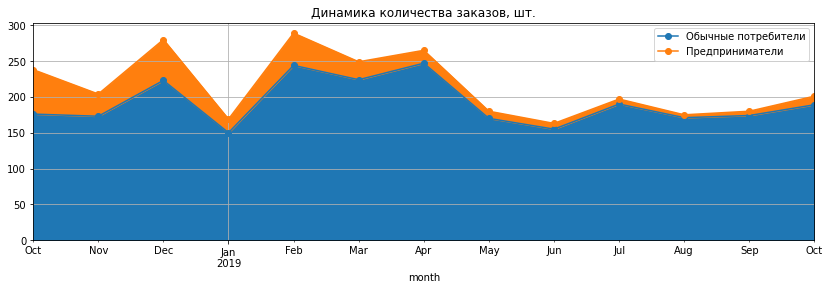

In [47]:
dynamic('order_id', 'nunique', 'Динамика количества заказов, шт.')

Количество заказов у предпринимателей упало. У обычных покупателей динамика количества заказов аналогична динамике количества покупателей (это логично, т.к. повторные покупки у нас характерны именно для предпринимателей).

#### Средний чек

Для более полного представления о текущей ситуации в нашем интернет-магазине изучим также средний чек:

In [48]:
def avg_order_value(data, header):
    '''
    Функция принимает датасет и заголовок,
    строит сводную таблицу по выручке и количеству заказов
    в разрезе по месяцам и типам покупателей,
    добавляет в таблицу расчет среднего чека,
    строит диаграмму на основе полученной таблицы
    '''
    # построение сводной таблицы
    aov = data.pivot_table(index='month', columns='b2b', values=['order_id','revenue'],
                           aggfunc={'order_id':'nunique','revenue':'sum'})\
                .reset_index()
    
    # переименование колонок сводной таблицы
    aov.columns = ['month', 'orders_b2c', 'orders_b2b', 'revenue_b2c', 'revenue_b2b']
    
    # добавление новых колонок в таблицу с расчетом среднего чека
    aov['aov_b2c'] = round(aov['revenue_b2c'] / aov['orders_b2c'],0)
    aov['aov_b2b'] = round(aov['revenue_b2b'] / aov['orders_b2b'],0)
    
    # вывод на печать сводной таблицы
    print(header)
    display(aov)
    
    # построение диаграммы
    aov.plot(figsize=(14,4), title=header, grid=True, style='-o', 
             y=['aov_b2c', 'aov_b2b'], stacked=True, kind='area',
            x='month')
    plt.xlabel('Месяц')
    plt.legend(['Обычные потребители','Предприниматели'])
    plt.show()    

Динамика среднего чека (у.е.) для всех заказов


,month,orders_b2c,orders_b2b,revenue_b2c,revenue_b2b,aov_b2c,aov_b2b
0,2018-10-01,176,62,240924.0,109824.0,1369.0,1771.0
1,2018-11-01,173,31,252060.0,107712.0,1457.0,3475.0
2,2018-12-01,223,57,237732.0,108007.0,1066.0,1895.0
3,2019-01-01,150,19,143956.0,90915.0,960.0,4785.0
4,2019-02-01,244,45,225928.0,80609.0,926.0,1791.0
5,2019-03-01,224,25,224228.0,32712.0,1001.0,1308.0
6,2019-04-01,247,18,252623.0,64068.0,1023.0,3559.0
7,2019-05-01,170,10,189473.0,42305.0,1115.0,4230.0
8,2019-06-01,155,8,168151.0,72027.0,1085.0,9003.0
9,2019-07-01,190,7,221805.0,4795.0,1167.0,685.0


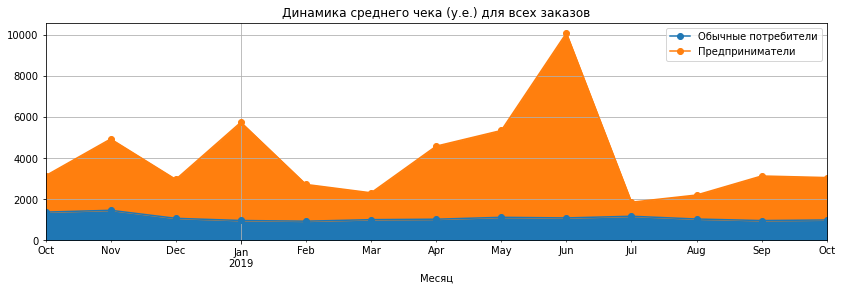

In [49]:
avg_order_value(df, 'Динамика среднего чека (у.е.) для всех заказов')

Для сравнения, сделаем то же самое для датафрейма без крупных заказов (более 9 000 у.е.):

Динамика среднего чека (у.е.) без учета крупных заказов (более 9 000 у.е.)


,month,orders_b2c,orders_b2b,revenue_b2c,revenue_b2b,aov_b2c,aov_b2b
0,2018-10-01,175,61,218868.0,100814.0,1251.0,1653.0
1,2018-11-01,172,29,227690.0,64117.0,1324.0,2211.0
2,2018-12-01,223,56,237732.0,75289.0,1066.0,1344.0
3,2019-01-01,150,17,143956.0,32280.0,960.0,1899.0
4,2019-02-01,243,44,209392.0,69609.0,862.0,1582.0
5,2019-03-01,224,25,224228.0,32712.0,1001.0,1308.0
6,2019-04-01,247,15,252623.0,22732.0,1023.0,1515.0
7,2019-05-01,170,8,189473.0,16349.0,1115.0,2044.0
8,2019-06-01,155,6,168151.0,11195.0,1085.0,1866.0
9,2019-07-01,189,7,206888.0,4795.0,1095.0,685.0


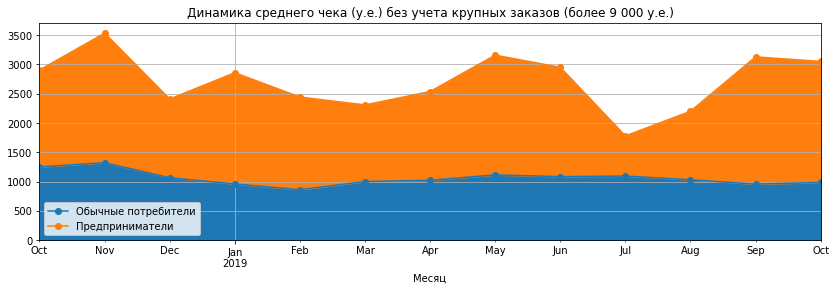

In [50]:
avg_order_value(df.query('order_id not in @large_orders_list'), 
                'Динамика среднего чека (у.е.) без учета крупных заказов (более 9 000 у.е.)')

Исключение из анализа крупных заказов сгладило пики, но не изменило тенденции.

Средний чек обычных массовых потребителей, приобретающих товары в небольших количествах для себя, весь период был относительно стабильным. Небольшое снижение есть (октябрь 2019 / октябрь 2018), но для прослеживания явной тенденции нужно рассматривать более длительный период, желательно 2 года.

Cредний чек предпринимателей имеет выраженную сезонность: 
- увеличение в сентябре-ноябре (подготовка к новому году), январе (простые люди отдыхают - у кафе, гостиниц и др.предприятий сферы услуг - высокий сезон), мае-июне (подготовка к летнему высокому сезону)
- снижение в июле-августе (время отпусков руководителй и персонала)

Итак, выручка у нас падает из-за снижения количества заказов предпринимателей.

### Вывод

**Количество покупателей и заказов**


За период с октября 2018 по октябрь 2019
- наш интернет-магазин посетили 2 422 покупателя;
- оформлено 2 783 заказа, т.е. повторных заказов 361 шт. или 13% от общего числа заказов;
- среди покупателей можно выделить обычных потребителей (95%) - покупают товары в количестве 1-2 шт., реже до 10 шт.  и предпринимателей (5%) - покупают от 10 шт. и более одного наименования;
- на обычных потребителей приходится 89% заказов (по количеству), на предпринимателей - 11%;


**Цены и аасортимент**


В магазине представлено (продано за анализируемый период) 2 337 наименований товаров.


Цены колеблются от 9 до 15 000 у.е.


Ассортимент товаров мы разделили на 3 ценовых сегмента:
- дешевые (до 200 у.е.) - 53% наименований
- средний ценовой сегмент (от 200 до 1200 у.е.) - 32% наименований
- дорогостоящие (свыше 1200 у.е.) - 14% наименований


**Стоимость заказов, выручка и средний чек**


Стоимость заказов:
- варьируется от 14 до 500 000 у.е. 
- медианная стоимость - 688 у.е.
- заказы стоимостью свыше 9000 у.е. мы сочли выбросами (крупными заказами), но не стали исключать из анализа, т.к. они либо относятся к заказам предпринимателей, либо содержат дорогостоящие позиции, т.е. при желании их можно отфильтровать и анализировать отдельно.

Выручка:
- динамика выручки по месяцам носит сезонный характер и аналогична динамике количества покупателей и динамике количества заказов;
- для обычных покупателей пики активности приходятся на декабрь, февраль-апрель и июль; спад наблюдается в январе и июне;
- для предпринимателей пики активности приходятся на февраль-апрель, а спад - на июль-август;
- выручка от продаж предпринимателям имеет тенденцию к снижению за счет уменьшения количества заказов.

Средний чек:
- средний чек обычных покупателей в течение всего периода колебался незначительно (от 900 до 1300 у.е. без учета крупных заказов, от 900 до 1500 с учетом крупных заказов);
- средний чек предпринимателей варьируется от 700 до 2200 у.е. без учета крупных заказов (от 700 до 9 000 у.е. с учетом крупных заказов);
- средний чек предпринимателей имеет выраженную сезонность: увеличение в сентябре-ноябре, январе, мае-июне; снижение в июле.

Для увеличения выручки рекомендуется:
- поощрять повторные и крупные заказы, особенно предпринимателей (скидки/бонусы - но выборочно и предварительно просчитав экономическую целесообразность);
- повышать средний чек за счет увеличения  количества позиций в заказе - рекомендовать всем покупателям сопутствующие товары.

## Анализ ассортимента

### Категории товаров по назначению

Чтобы разбить ассортимент на категории по назначению, сначала приведем названия товаров к нижнему регистру, заменим ё на е, удалим кавычки, скобки, знаки препинания, символы и лишние пробелы:

In [51]:
df['product'] = df['product'].str.lower()

replace_values={'"':'',
               '(':'',
               ')':'',
               '  ':' ',
               'ё':'е',
               '-':' ',
               ',':'',
               '.':'',
               ':':'',
               '+':'',
               '=':'',
               '/':'',
               '%':'',
               '*':'',
               '_':'',
               '№':''}

def multiple_replace(row, replace_values):
    '''
    Функция, которая принимает исходную строку и словарь замен,
    а возвращает измененную строку
    '''
    for i, j in replace_values.items():
        row = row.str.replace(i, j)
    return row

df['product'] = multiple_replace(df['product'], replace_values)
df.head(10)

,date,customer_id,order_id,product,quantity,price,revenue,b2b,price_level,month
0,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,комнатное растение в горшке алое вера d12 h30,1,142.0,142.0,False,Дешевые,2018-10-01
1,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,комнатное растение в горшке кофе арабика d12 h25,1,194.0,194.0,False,Дешевые,2018-10-01
2,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,радермахера d 12 см h 20 см,1,112.0,112.0,False,Дешевые,2018-10-01
3,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,хризолидокарпус лутесценс d 9 см,1,179.0,179.0,False,Дешевые,2018-10-01
4,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,циперус зумула d 12 см h 25 см,1,112.0,112.0,False,Дешевые,2018-10-01
5,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,шеффлера лузеана d 9 см,1,164.0,164.0,False,Дешевые,2018-10-01
6,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,юкка нитчатая d 12 см h 25 35 см,1,134.0,134.0,False,Дешевые,2018-10-01
7,2018-10-01 08:00:00,375e0724-f033-4c76-b579-84969cf38ee2,68479,настенная сушилка для белья gimi brio super 100,1,824.0,824.0,False,Средний ценовой сегмент,2018-10-01
8,2018-10-01 08:00:00,6644e5b4-9934-4863-9778-aaa125207701,68478,таз пластмассовый 210 л круглый водолей с614 1404056,1,269.0,269.0,False,Средний ценовой сегмент,2018-10-01
9,2018-10-01 09:00:00,c971fb21-d54c-4134-938f-16b62ee86d3b,68480,чехол для гладильной доски colombo persia beige 130х50 см из хлопка 5379,1,674.0,674.0,True,Средний ценовой сегмент,2018-10-01


Попробуем сформировать список ключевых слов, по которым будем выделять категории. Для этого сначала объединим все названия в строку:

In [52]:
products_list = df['product'].unique()
key_words = ' '.join(products_list)

Теперь удалим цифры:

In [53]:
key_words = re.sub('\d+', '', key_words)

Далее удалим слова короче 3х букв:

In [54]:
key_words = re.findall(r'\b\w{3,}\b', key_words)
key_words

['комнатное',
 'растение',
 'горшке',
 'алое',
 'вера',
 'комнатное',
 'растение',
 'горшке',
 'кофе',
 'арабика',
 'радермахера',
 'хризолидокарпус',
 'лутесценс',
 'циперус',
 'зумула',
 'шеффлера',
 'лузеана',
 'юкка',
 'нитчатая',
 'настенная',
 'сушилка',
 'для',
 'белья',
 'gimi',
 'brio',
 'super',
 'таз',
 'пластмассовый',
 'круглый',
 'водолей',
 'чехол',
 'для',
 'гладильной',
 'доски',
 'colombo',
 'persia',
 'beige',
 'хлопка',
 'вешалка',
 'для',
 'брюк',
 'металлическая',
 'резиновым',
 'покрытием',
 'цвет',
 'синяя',
 'attribute',
 'ahs',
 'сушилка',
 'для',
 'белья',
 'потолочная',
 'zalger',
 'lift',
 'basic',
 'чехол',
 'eurogold',
 'clean',
 'basic',
 'хлопок',
 'для',
 'досок',
 'крючок',
 'одежный',
 'рожковый',
 'серый',
 'металлик',
 'полимерным',
 'покрытием',
 'тонар',
 'корзина',
 'мягкая',
 'пластиковая',
 'пластика',
 'чехол',
 'для',
 'гладильной',
 'доски',
 'festival',
 'хлопка',
 'сумка',
 'тележка',
 'колесная',
 'gimi',
 'argo',
 'синяя',
 'многолетнее

У нас получился список, а для лемматизации нужна строка:

In [55]:
key_words = ' '.join(key_words)
type(key_words)

str

Теперь можно подсчитать количество одинаковых слов:

In [56]:
count_words = Counter(m.lemmatize(key_words))

Но чтобы было удобнее пользоваться результатом, преобразуем его в датафрейм:

In [57]:
count_words_df = pd.DataFrame.from_dict(count_words, orient='index').reset_index()
count_words_df.columns = ['word', 'count']
count_words_df.sort_values(by='count', ascending=False).head(50)

,word,count
1,,13341
19,для,545
71,рассада,221
1723,сорт,171
76,кассета,170
144,белый,164
20,белье,142
91,красный,141
30,доска,132
3,горшок,130


Заведем 8 категорий: Интерьер, Хозтовары, Растения, Посуда, Текстиль, Стройка, Бытовая техника, Косметика и гигиена. Для каждой категории составим список ключевых слов. Сначала возьмем результаты лемматизации, потом будем корректировать вручную, проверяя каждый раз строки, по которым категория еще не присвоена.

In [58]:
interior = ['муляж', 'интерьерный', 'искусственный', 'ковер', 'искуственных', 'комод', 'фоторамка', 'этажерка', 'полки', 
            'ключница', 'искусственная','гипсофила', 'полка', 'венге', 'стеллаж', 'пуф']

household = ['сушилка', 'белье', 'таз', 'гладильная', 'вешалок', 'вешалка', 'крючок', 'корзина', 'сумка', 'щетка', 'ручка', 
             'ерш', 'прищепок', 'коврик', 'унитазный','мусорный','сумка-тележка', 'посуды', 'кофр', 'подрукавник', 'штора',
            'чехол', 'дозатор','перчатки','щетка-сметка', 'плечики', 'стиральный', 'чистящий', 'ванной', 'карниз', 'веник',
             'щетка-утюжок',  'контейнер', 'швабра', 'ящик', 'короб', 'вешалка-плечики', 'коробка','термометр', 'моп',
            'швабры', 'сиденье', 'шнур',  'сметка', 'линейка', 'швабре','удаления', 'бензин', 'полировки', 'шило',
             'вешалка-стойка', 'держатель', 'пробка', 'вешалки', 'губка', 'антижир', 'средство', 'чистки', 'сменный',
            'ковш', 'рассекатель', 'посудомоечных', 'глажения', 'подставка', 'вешалка-сушилка', 'мыльница', 'подголовник',
            'кольца', 'вантуз', 'белья', 'вешалка-перекладина', 'ведра', 'нетканые', 'гладильной', 'урна-пепельница', 'ткань',
            'насадка-моп', 'тряпкодержатель', 'прищепки', 'скребок', 'мытья', 'антинакипин', 'окномойка', 'бидон', 'корзинка', 
             'отбеливатель', 'стирки', 'пьезозажигалка', 'ерша', 'хранения', 'тряпка', 'совок', 'тележка', 'мусора', 'ведро']

plants = ['рассада', 'радермахера', 'хризолидокарпус', 'циперус', 'шеффлера', 'юкка', 'многолетнее','герань', 'пеларгония',
         'суккулент','эхеверия', 'кашпо', 'эвкалипт', 'адиантум','растение', 'кампанула', 'калатея', 'нолина', 'хлорофитум',
         'цикламен', 'глоксиния', 'азалия', 'гортензия', 'кассете', 'среднеспелый', 'хризантема', 'мирт', 'иссоп',
         'сантолина', 'аспарагус', 'антуриум', 'молодило', 'фиалка', 'гербера', 'душица', 'мелисса', 'роза', 'бегония',
         'розмарин', 'альбука', 'бальзамин', 'крассула', 'артемизия', 'лаванда', 'мята', 'каланхое', 'примула', 'дендробиум',
         'калоцефалус', 'каллуна', 'капсикум', 'мимоза', 'соланум', 'бархатцы', 'морковь', 'настурция', 'огурец', 'петуния',
         'космея', 'алиссум', 'гвоздика', 'годеция', 'календула', 'капуста', 'кореопсис', 'лапчатка', 'флокс', 'цинерария',
         'эшшольция', 'диффенбахия', 'фаленопсис', 'подсолнечник', 'пуансетия', 'черенок', 'аптения', 'ель', 'пуансеттия',
         'скиммия', 'фиттония', 'тимьян', 'алоэ', 'спатифиллум', 'фикус', 'гимнокалициум', 'кофе', 'эхинокактус', 'крокусы',
         'тюльпаны', 'ампельная', 'эпипремнум','гиацинты', 'аквилегия', 'базилик', 'горох', 'земляника', 'незабудка',
         'седум', 'томат', 'укроп', 'нефролепис', 'крупноцветковая', 'горшке', 'тюльпан', 'луковиц', 'чабер', 'калибрахоа',
         'ранункулус', 'овсянница', 'георгина', 'смолевка', 'цинния', 'вербейник', 'ясколка', 'колокольчик', 'котовник', 
          'микс', 'афеляндра', 'объем', 'штамбовая', 'пеперомия', 'дыня', 'синнингия', 'томата', 'гардения', 'виноград', 
          'муррайя', 'раннеспелый', 'позднеспелая', 'баклажан', 'клубника', 'патиссон', 'джункус', 'драцена', 'арбуз', 'фатсия',
         'осина', 'лавр', 'лантана', 'лаватера', 'хамедорея', 'зверобой', 'мединилла', 'замиокулькас', 'петрушка', 'рукола',
         'пахира', 'кипарисовик']

tableware = ['тарелка', 'обеденный', 'вилка', 'столовая', 'ложка', 'чайная', 'нож', 'столовый', 'посуда','кружек', 'кружка',
          'фужеров', 'пищевой', 'кувшин','толкушка','банка', 'противень', 'сковороды', 'tepмокружка', 'мини-сковорода',
            'сковорода', 'luminarc', 'салатников','овощеварка', 'терка', 'рыбочистка', 'ножеточка', 'лопатка', 'салфетница',
            'овощечистка', 'измельчитель', 'лоток', 'мантоварка', 'стаканов','кухонные', 'ножей', 'выпечки',
            'кондитерский', 'картофелемялка', 'кексов', 'миска', 'чеснока', 'термостакан', 'столовых', 'термокружка', 'термос',
            'разделочная', 'мантоварка-пароварка', 'соуса', 'просеиватель', 'кастрюля', 'хлебница', 'емкость', 'орехоколка',
            'скалка', 'венчик', 'сито', 'тортница', 'блюдо', 'сотейник', 'отделитель', 'крышка', 'сахарница', 'соковарка',
            'цитрусовых', 'половник', 'салатник', 'напитков', 'стакан']

textile = ['плед', 'простыня', 'подушка', 'подушка', 'полотенце', 'скатерть', 'салфетка', 'наматрасник', 'наматрицник-чехол',
          'халат', 'полотенец', 'покрывало', 'одеяло', 'салфеток', 'простынь', 'наматрацник', 'наволочка', 'пододеяльник',
          'хлопковый']

construction = ['гаражная', 'батарея', 'котел', 'лестница-стремянка','стяжка', 'стремянка', 'крепеж', 'пружина', 'стремянки',
               'сверел', 'сверло-фреза', 'корыто', 'сварка', 'угольник', 'петля-стрела', 'ручка-скоба', 'инструмент',
                'стремянка-табурет', 'петля', 'бухте', 'штангенциркуль', 'напильников', 'сверло', 'фиксатор-шар', 'шпагат', 
                'ванна', 'веревка', 'строительного', 'инструментов', 'форточная', 'вентиляционная', 'уголок', 'шпингалет',
               'пробки', 'строительное', 'урна', 'урна', 'фиксатор']

appliances = ['чайник', 'миксер', 'утюг', 'фен', 'весы', 'электроштопор', 'пылесос', 'кипятильник', 'светильник']

cosmetics = ['ванн','зубная','мыло', 'увлажняющая', 'мыло-скраб']

Теперь напишем функцию, которая будет искать в названии товара ключевое слово и присваивать этому товару  соответствующую категорию:

In [59]:
def get_category(row):
    product_name = row.split(' ')
    
    for word in product_name:
            if word in interior:
                return 'Интерьер'
            if word in appliances:
                return 'Бытовая техника'
            if word in cosmetics:
                return 'Косметика и гигиена'
            if word in tableware:
                return 'Посуда'
            if word in textile:
                return 'Текстиль'
            if word in household:
                return 'Хозтовары'
            if word in plants:
                return 'Растения'
            if word in construction:
                return 'Стройка'
    return 'нет данных'

df['product_category'] = df['product'].apply(get_category)

# проверим, всем ли товарам присвоена категория:
df.query('product_category == "нет данных"')

,date,customer_id,order_id,product,quantity,price,revenue,b2b,price_level,month,product_category


In [60]:
df.sample(5)

,date,customer_id,order_id,product,quantity,price,revenue,b2b,price_level,month,product_category
1675,2019-02-04 06:00:00,909564b8-3a5c-4d3e-8310-5ba1c837bbd7,70080,мусорный контейнер hailo bigbin swing 45 0845 010 45 л хром,3,5512.0,16536.0,False,Дорогостоящие,2019-02-01,Хозтовары
6123,2019-08-17 10:00:00,79e65126-3b66-4822-a1a1-d915b14070a5,72321,пеларгония розебудная prins nikolai укорененный черенок,1,134.0,134.0,False,Дешевые,2019-08-01,Растения
2976,2019-04-20 08:00:00,16838b36-762a-474d-bda4-bad95f8d7813,71209,автоматическая щетка leifheit для мытья окон с ручкой 43 см 51114,1,7229.0,7229.0,False,Дорогостоящие,2019-04-01,Хозтовары
4034,2019-05-26 09:00:00,14af8c4f-98fe-486a-b139-9a0507fb6a52,71515,кружка тачки 250мл e9131 h1496 luminarc франция,1,284.0,284.0,False,Средний ценовой сегмент,2019-05-01,Посуда
3752,2019-05-14 11:00:00,a3394ff2-4cd2-4332-9f6c-2668ac608fbc,14769,томата помидор этуаль 85 сорт детерминантный среднеспелый розовый,1,38.0,38.0,False,Дешевые,2019-05-01,Растения


Категории по назначению присвоены, теперь сгруппируем товары по новым категориям и сравним показатели.

### Разделение на основной и дополнительный ассортимент 

In [61]:
def analys(data, val, func, header):
    '''
    Функция принимает датафрейм, показатель, функцию и заголовок,
    строит сводную таблицу для показателя в разрезе товарных катгорий и ценовых сегментов,
    затем выводит столбчатую диаграмму
    '''
    pivot = data.pivot_table(index='product_category', columns='price_level', values=val, aggfunc=func)\
            .reset_index()
    pivot = pivot.fillna(0)
    pivot['total'] = pivot['Дешевые'] + pivot['Дорогостоящие'] + pivot['Средний ценовой сегмент']
    pivot = pivot.sort_values(by='total', ascending=False)
    pivot['total_share'] = round(pivot['total'] / pivot['total'].sum(),2)
    display(pivot)
    
    pivot.plot(x='product_category', y=['Дешевые', 'Средний ценовой сегмент', 'Дорогостоящие'],
          kind='bar', stacked=True, figsize=(14,6), rot=45,
          title=header);


price_level,product_category,Дешевые,Дорогостоящие,Средний ценовой сегмент,total,total_share
7,Хозтовары,171623.0,1095019.0,753070.0,2019712.0,0.59
4,Растения,353918.0,35156.0,132525.0,521599.0,0.15
3,Посуда,70709.0,38238.0,115884.0,224831.0,0.07
6,Текстиль,21026.0,123071.0,74698.0,218795.0,0.06
1,Интерьер,109424.0,76208.0,22333.0,207965.0,0.06
5,Стройка,25095.0,157886.0,21268.0,204249.0,0.06
0,Бытовая техника,0.0,11064.0,25010.0,36074.0,0.01
2,Косметика и гигиена,2593.0,0.0,5836.0,8429.0,0.00


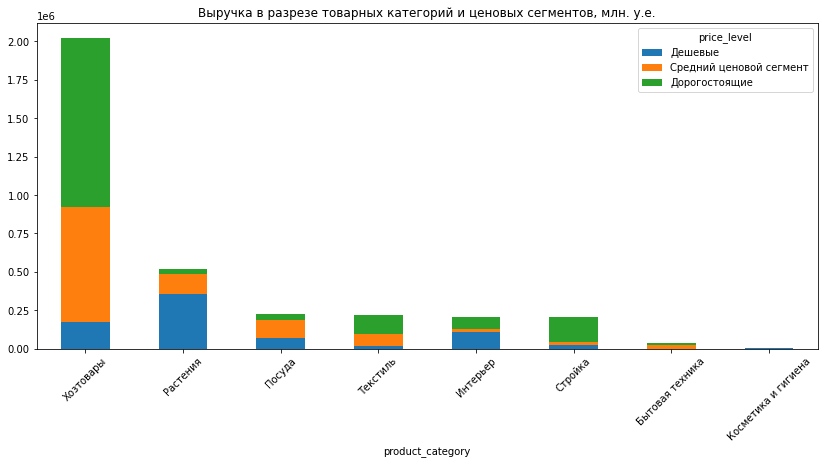

In [62]:
analys(df, 'revenue', 'sum', 'Выручка в разрезе товарных категорий и ценовых сегментов, млн. у.е.')

Больше всего выручки приносят нам Хозтовары - порядка 2 млн. у.е. или 59%. При этом чуть больше половины выручки от Хозтоваров приносят дорогостоящие товары. Очевидно, что Хозтовары для нас - это основной ассортимент.

На втором месте по доле в выручке - растения - 0,5 млн. у.е. или 15%. Данная категория - чемпион по дешевым товарам (т.к. в эту категорию попадают семена и рассада).

Посуда, Текстиль, Интерьер и Стройка имеют примерно одинаковую долю в выручке - по 0,2 млн. у.е. или 6-7%. 

Бытовая техника а также Косметика и гигиена практически незаметны в выручке и однозначно являются дополнительным ассортиментом (сопутствующими товарами).

Посмотрим теперь, как распределяется по категориям количество проданных товаров в штуках:

price_level,product_category,Дешевые,Дорогостоящие,Средний ценовой сегмент,total,total_share
7,Хозтовары,2282.0,394.0,1360.0,4036.0,0.32
4,Растения,3374.0,17.0,377.0,3768.0,0.30
1,Интерьер,2378.0,35.0,41.0,2454.0,0.19
3,Посуда,766.0,22.0,270.0,1058.0,0.08
5,Стройка,817.0,50.0,27.0,894.0,0.07
6,Текстиль,162.0,63.0,119.0,344.0,0.03
0,Бытовая техника,0.0,6.0,31.0,37.0,0.00
2,Косметика и гигиена,30.0,0.0,7.0,37.0,0.00


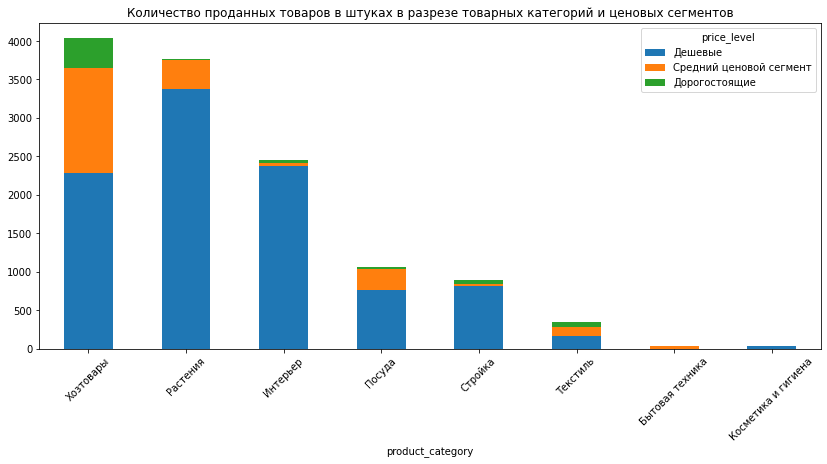

In [63]:
analys(df, 'quantity', 'sum', 'Количество проданных товаров в штуках в разрезе товарных категорий и ценовых сегментов')

По штукам Растения не далеко ушли от лидера - Хозтоваров и занимают долю в 30%. Поэтому растения тоже отнесем к основному ассортименту.

Интерьер - 19% - под вопросом, смущает то, что основная масса товаров данной группы относится к дешевым, очень мало товаров среднего ценового сегмента и дорогостоящих. Посмотрим на остальные показатели данной категории.

Изучим теперь количество заказов: какая доля заказов содержит в себе ту или иную группу товаров.

price_level,product_category,Дешевые,Дорогостоящие,Средний ценовой сегмент,total,total_share
7,Хозтовары,216.0,371.0,804.0,1391.0,0.48
4,Растения,628.0,13.0,166.0,807.0,0.28
1,Интерьер,192.0,31.0,28.0,251.0,0.09
3,Посуда,118.0,20.0,110.0,248.0,0.08
5,Стройка,29.0,44.0,22.0,95.0,0.03
6,Текстиль,22.0,23.0,40.0,85.0,0.03
0,Бытовая техника,0.0,6.0,29.0,35.0,0.01
2,Косметика и гигиена,7.0,0.0,3.0,10.0,0.00


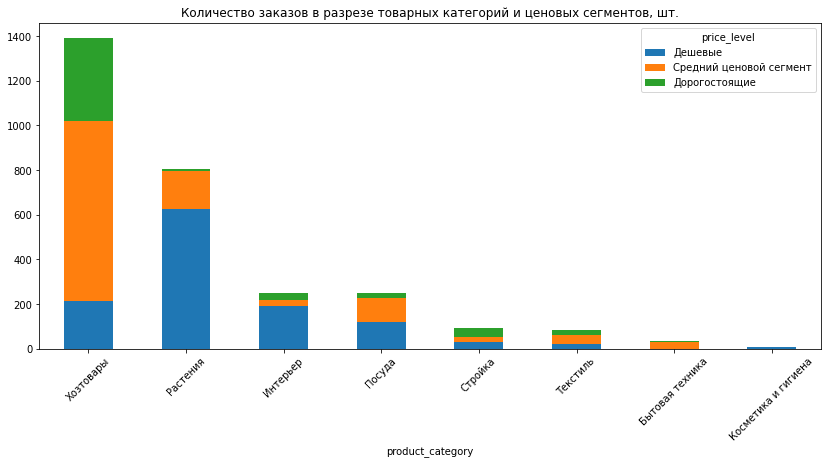

In [64]:
analys(df, 'order_id', 'nunique', 'Количество заказов в разрезе товарных категорий и ценовых сегментов, шт.')

Все-таки Интерьер не дотягивает до основного ассортимента, товары этой группы присутствуют только в 9% заказов, тогда как Хозтовары - в 48%, а растения - в 28%.

Итак, основной ассортимент нашего интернет-магазина - это Хозтовары и Растения, все остальное - дополнительный ассортимент (сопутствующие товары).  Для рекламы, баннеров, главных экранов, первых позиций в каталоге рекомендуется брать только основной ассортимент.

В рекомендации можно включать как основной, так и дополнительный. 

### Анализ сезонности

Чтобы проанализировать сезонность каждой категории, посчитаем количество заказов с этой категорией для каждого месяца:

In [65]:
season_products = df.pivot_table(index='month', columns='product_category', 
                                 values='order_id', aggfunc='nunique')
season_products = season_products.fillna(0)
season_products

product_category,Бытовая техника,Интерьер,Косметика и гигиена,Посуда,Растения,Стройка,Текстиль,Хозтовары
month,,,,,,,,
2018-10-01,5.0,16.0,2.0,23.0,37.0,15.0,10.0,152.0
2018-11-01,2.0,20.0,1.0,28.0,30.0,6.0,11.0,123.0
2018-12-01,6.0,14.0,1.0,39.0,52.0,8.0,12.0,152.0
2019-01-01,5.0,15.0,0.0,22.0,26.0,7.0,8.0,86.0
2019-02-01,3.0,35.0,2.0,27.0,75.0,6.0,8.0,135.0
2019-03-01,3.0,24.0,2.0,23.0,86.0,5.0,5.0,101.0
2019-04-01,3.0,37.0,0.0,9.0,103.0,6.0,3.0,104.0
2019-05-01,0.0,11.0,0.0,11.0,96.0,5.0,2.0,55.0
2019-06-01,0.0,8.0,0.0,7.0,53.0,5.0,6.0,84.0


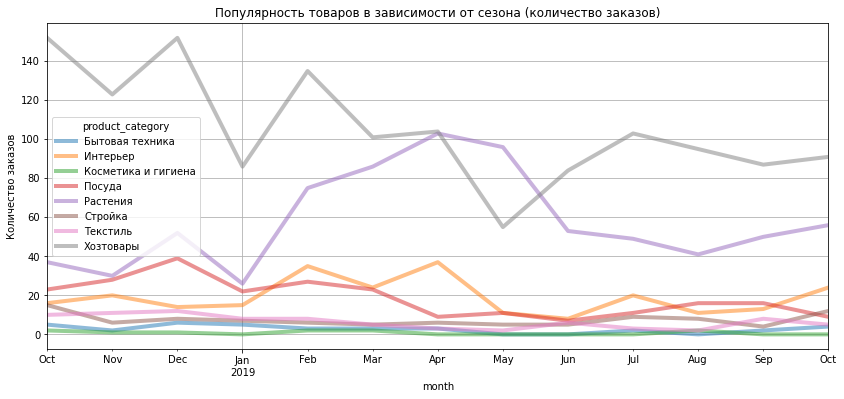

In [66]:
season_products.plot(figsize=(14,6), grid=True, ylabel='Количество заказов',
                    title='Популярность товаров в зависимости от сезона (количество заказов)',
                    linewidth=4, alpha=0.5);

У Хозтоваров спады в мае и январе (видимо, сказывается обилие выходных дней, которые люди стремятся провести вне дома), пики в декабре и феврале (наведение порядка перед новым годом и 8 марта). Но поскольку это основной ассортимент, рекламировать их и рекомендовать можно независимо от сезона.

Растения наиболее популярны с февраля по май - время выращивания рассады и первых посадок на огороде, наименее популярны в ноябре и январе. В декабре спада нет, т.к. пользуются популярностью горшечные растения - в качестве подарков и украшений к новому году. Растения желательно активно рекламировать и рекомендовать в соответствии с сезоном: горшечные - осенью и зимой, семена - с февраля по май, рассаду - с апреля по июнь, саженцы - с мая по сентябрь.

Категория Интерьер (куда входит мебель, ковры, искусственные цветы и фрукты) наиболее востребована с февраля по апрель - время весеннего обновления, завершения ремонтов и подготовки к лету. В этот период данную категорию можно включать в рекомендации более активно, чем в другие периоды.

Категория Посуда более популярна с ноября по март, менее популярна с апреля по октябрь - время дач и путешествий, когда готовить обычно некогда. Соответственно посуду активнее продвигаем с ноября по март.

По остальным категориям сезонность не прослеживается, рекомендовать можно круглый год.

### Вывод

**Основной ассортимент** интернет-магазина составляют Хозтовары и Растения.

Хозтовары
- занимают 59% продаж в денежном выражении, 32% в натуральном выражении, присутствуют в 48% заказов.
- категория является сбалансированной по ценовым сегментам, расширения ассортимента не требуется, но и не возбраняется.
- рекомендуется продвигать, рекламировать и включать в рекомендации независимо от сезона.

Растения
- занимают 15% выручки, 30% объема продаж в натуральном выражении, содержатся в 28% заказов.
- категория состоит, в основном, из дешевых товаров, рекомендуется расширять ассортимент за счет товаров среднего ценового сегмента (от 200 до 1200 у.е.) - саженцев, горшечных растений, наборов рассады, а также дорогостоящих товаров (свыше 1200 у.е.) - редких/экзотических/крупных саженцев, горшечных растений.
- рекомендуется рекламировать и рекомендовать в соответствии с сезоном: горшечные - осенью и зимой, семена - с февраля по май, рассаду - с апреля по июнь, саженцы - с мая по сентябрь.

**Дополнительный ассортимент**  - все остальные категории

Интерьер (мебель, ковры, искусственные цветы, аксессуары)
- занимает 6% выручки, 19% объема продаж в натуральном выражении, содержится в 9% заказов.
- имеет потенциал перехода в основной ассортимент.
- по количеству преобладают дешевые товары, если хотим переводить в основной ассортимент, рекомендуется расширять товарную номенклатуру за счет среднего ценового сегмента (от 200 до 1200 у.е.) и дорогостоящих товаров (свыше 1200 у.е.) - наиболее популярных и востребованных предметов мебели класса масс-маркет.
- текущий ассортимент наиболее востребован с февраля по апрель, однако в случае расширения ассортимента за счет мебели, пиком спроса будет август-декабрь (исходя из моего опыта работы в мебельной отрасли).
- в случае перехода в основной ассортимент продвигать категорию рекомендуется круглый год, в низкий сезон (лето) желательно устраивать распродажи.
- если расширять не планируем и оставляем в качестве дополнительного ассортимента, то более активно рекомендуем с февраля по апрель.

Посуда
- занимает 7% выручки, 8% объема продаж в натуральном выражении, содержится в 8% заказов.
- по количеству преобладают дешевые товары (до 200 у.е.), товары среднего ценового диапазона и дорогостоящие также присутствуют.
- рекомендуется более активно рекомендовать с ноября по март

Стройка (товары для ремонта)
- занимает 6% выручки, 7% объема продаж в натуральном выражении, содержится в 3% заказов.
- по количеству преобладают дешевые товары (до 200 у.е.), товары среднего ценового диапазона и дорогостоящие также присутствуют.
- текущий ассортимент востребован одинаково весь год, рекомендовать независимо от сезона

Текстиль (полотенца, постельное белье, салфетки, скатерти, халаты)
- занимает 6% выручки, 3% объема продаж в натуральном выражении, содержится в 3% заказов.
- по количеству преобладают дешевые товары (до 200 у.е.), товары среднего ценового диапазона и дорогостоящие также присутствуют.
- текущий ассортимент востребован одинаково весь год, рекомендовать независимо от сезона

Бытовая техника (чайники, утюги, светильники, кипятильники, фены, миксеры, весы, пылесосы)
- занимает 1% выручки, менее 1% объема продаж в натуральном выражении, содержится в 1% заказов.
- по количеству преобладают товары среднего ценового диапазона (от 200 до 1200 у.е.)
- текущий ассортимент востребован одинаково весь год, рекомендовать независимо от сезона 

Косметика и гигиена (мыло, пена для ванн, маски для лица, зубная паста)
- занимает менее 1% выручки, объема продаж в натуральном выражении и заказов.
- по количеству преобладают дешевые товары (до 200 у.е.)
- текущий ассортимент востребован одинаково весь год, рекомендовать независимо от сезона.

## Проверка гипотез

### Выбор показателя и формулирование гипотезы

Наиболее важным показателем у нас является выручка. Основная цель исследования - анализ ассортимента. Значит, логично будет проверить гипотезу о том, какие доли занимают у нас разные ассортиментные группы в выручке.

Ассортимент мы поделили по ценовым сегментам и по 8 категориям назначения. Категории назначения можно объединить в 2 группы - основной и дополнительный ассортимент.

Интересно проверить, различаются ли доли ценовых сегментов в выручке для основного и дополнительного ассортимента. Гипотезу на человеческом языке сформулируем так: **основной и дополнительный ассортимент имеют разную структуру по ценовым сегментам**. 

Т.е. например, доля дешевых товаров в основном ассортименте отличается от доли дешевых товаров в дополнительном ассортименте. На графиках мы сейчас видим это различие, однако не является ли оно случайным? Что если мы возьмем другой период (более длительный), то получим равные доли для ценовых сегментов?

### Подготовка данных для проверки гипотезы

Сначала нам нужно пометить основной и дополнительный ассортимент в отдельном столбце:

In [67]:
def priority(category):
    
    if category == 'Хозтовары' or category == 'Растения':
        return 'main'
    return 'additional'


df['priority'] = df['product_category'].apply(priority)

In [68]:
df.sample(5)

,date,customer_id,order_id,product,quantity,price,revenue,b2b,price_level,month,product_category,priority
67,2018-10-03 10:00:00,d0c6d3d9-dc3b-4406-afb7-f6cb0da3a4a9,68515,коврик bacchetta magicstop 03x15 м бежевый для сушки посуды 2289,1,187.0,187.0,False,Дешевые,2018-10-01,Хозтовары,main
6574,2019-10-10 17:00:00,21a6f64a-52bc-48b2-b6e3-e7d197620b08,72924,термокружка яромир кремль яр 2406м 400 мл,1,225.0,225.0,False,Средний ценовой сегмент,2019-10-01,Посуда,additional
1044,2018-12-01 17:00:00,95d35195-81d6-400c-9f2d-bdc947d6c5bd,69163,сумка тележка 2 х колесная gimi argo синяя,1,1049.0,1049.0,False,Средний ценовой сегмент,2018-12-01,Хозтовары,main
920,2018-11-23 04:00:00,81a07ad7-0646-477c-9e11-0a52c6f6f7e1,69090,герань домашняя пеларгония зональная цветущая d12 h25 30 малиновая махровая,1,149.0,149.0,False,Дешевые,2018-11-01,Растения,main
5206,2019-06-13 09:00:00,3a6d1d0f-af18-4baa-ae90-3b481469d6eb,14862,пеларгония зональная мультиблум скарлет ай d 7 см h 10 см укорененный черенок,1,75.0,75.0,False,Дешевые,2019-06-01,Растения,main


Рассчитаем общую сумму выручки для основного и дополнительного ассортимента:

In [69]:
df.groupby('priority').agg({'revenue':'sum'})

,revenue
priority,
additional,900343.0
main,2541311.0


Теперь сформируем сводную таблицу для выручки в разрезе ценовых категорий и основного/дополнительного ассортимента, добавим в нее строку Итого:

In [70]:
compare = df.pivot_table(index='price_level', columns='priority', values='revenue', aggfunc='sum')\
            .sort_values(by='main', ascending=False)\
            .reset_index()
new_raw = {'price_level':'Итого', 'main':2541311, 'additional':900343}
compare = compare.append(new_raw, ignore_index=True)

compare

,price_level,additional,main
0,Дорогостоящие,406467.0,1130175.0
1,Средний ценовой сегмент,265029.0,885595.0
2,Дешевые,228847.0,525541.0
3,Итого,900343.0,2541311.0


Данные для проверки гипотезы о равенстве долей готовы.

### Написание  функции для проверки гипотезы

Чтобы можно было менять количество групп и уровень статистической значимости при необходимости, удобно написать функцию.

Напишем функцию, которая будет проверять гипотезу о равенстве долей для заданных видов ассортимента по каждому ценовому сегменту. Будем использовать Z-тест, зададим уровень значимости  𝛼  = 0.017.

Здесь мы используем поправку Бенферрони для  𝛼  = 0.05, разделив это значение на 3, т.к. у нас будет 3 проверки для 2х групп и 3х ценовых сегментов.

In [71]:
def test(group1, group2, set_alpha = 0.017):
    
    alpha = set_alpha
    
    # перебираем список из 3х сегментов 
    for i in range(3):
            
        # пропорция для первой группы
        p1 = compare.loc[i, group1] / compare.loc[3,group1]

        # пропорция для второй группы
        p2 = compare.loc[i, group2] / compare.loc[3,group2]

        # пропорция для комбинации групп
        p_comb = ((compare.loc[i, group1] + compare.loc[i, group2]) / 
                  (compare.loc[3, group1] + compare.loc[3, group2]))

        # разница пропорций
        dif = p1 - p2

        # считаем статистику в ст.отклонениях стандартного нормального распределения
        z_value = dif / mth.sqrt(
            p_comb * (1 - p_comb) * (1 / compare.loc[3,group1] + 1 / compare.loc[3,group2])
        )

        # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
        distr = st.norm(0, 1)

        p_value = (1 - distr.cdf(abs(z_value))) * 2

        print('Ценовой сегмент:', i)
        print('p-значение: ', p_value)

        if p_value < alpha:
            print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
        else:
            print(
            'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'
            )
        print()
        
        # переходим к следующему ценовому сегменту
        i += 1

### Проверка гипотезы о равенстве долей

**Нулевая гипотеза**: между долями товаров основного и дополнительного ассортимента в выручке для одного и того же ценового сегмента нет статистически значимых различий.

**Альтернативная гипотеза**: доли товаров основного и дополнительного ассортимента в выручке для одного и того же ценового сегмента различаются.

Проверим:

In [72]:
test('main','additional')

Ценовой сегмент: 0
p-значение:  0.0
Отвергаем нулевую гипотезу: между долями есть значимая разница

Ценовой сегмент: 1
p-значение:  0.0
Отвергаем нулевую гипотезу: между долями есть значимая разница

Ценовой сегмент: 2
p-значение:  0.0
Отвергаем нулевую гипотезу: между долями есть значимая разница



### Уровень значимости и групповой коэффициент ошибок

Мы провели множественную проверку гипотезы - по 1 тесту для каждого из 3-х ценовых сегментов, всего 3 сравненя. Уровень статистической значимости для каждого теста задали на уровне = 0.017. Групповой коэффициент ошибок в нашем случае будет равен:

In [73]:
alpha = 0.017
fwer = 1 - (1 - alpha)**3
fwer

0.050137913000000034

5% - это приемлемая вероятность ошибки.

### Вывод

Мы провели множественный тест, в ходе которого сравнили между собой выручку от продажи товаров основного и дополнительного асортимента.

Показатели для сравнения:
- доля дешевых товаров в выручке;
- доля товаров среднего ценового сегмента в выручке;
- доля дорогостоящих товаров в выручке.


Уровень статистической значимости был задан на уровне 1,7%. Групповой коэффициент ошибок равен 5%.

Тест показал, что между одними и теми же показателями разных групп есть статистически значимые различия. 

Основной и дополнительный ассортимент отличаются структурой по ценовым сегментам. 

Практическое применение: если мы захотим какую-то категорию товаров перевести в из дополнительного ассортимента в основной или наоборот, то нам нужно будет поменять соотношение ценовых сегментов в данной категории.

## Выводы и рекомендации

**Общее описание ситуации**

За период с октября 2018 по октябрь 2019
- интернет-магазин посетили 2 422 покупателя;
- продано 2 337 наименований товаров;
- оформлено 2 783 заказа, 
- повторных заказов 361 шт. или 13% от общего числа заказов;
- 95% покупателей - обычные потребители, на которых приходится 89% заказов, средний чек не зависит от сезона и колеблется от 900 до 1300 у.е. (без учета выбросов);
- 5% покупателей - предприниматели, на которых приходится 11% заказов, средний чек имеет выраженную сезонность и варьируется от 700 до 2200 у.е. (без учета выбросов);
- выручка имеет тенденцию к снижению за счет уменьшения количества заказов предпринимателей.


**Ассортимент**

Мы разделили товары на 3 ценовых сегмента:
 - дешевые (до 200 у.е.) - 53% наименований
 - средний ценовой сегмент (от 200 до 1200 у.е.) - 32% наименований
 - дорогостоящие (от 1200 до 15000 у.е.) - 14% наименований
 
Выделили 8 товарных категорий по назначению и 2 супер-категории по приоритету:
- Основной ассортимент (74% выручки и 62% продаж в шт)
 - Хозтовары (59% выручки и 32% продаж в шт)
 - Растения (15% выручки и 30% продаж в шт)
- Дополнительный ассортимент (26% выручки и 38% продаж в шт)
 - Интерьер (6% выручки и 19% продаж в шт)
 - Посуда (7% выручки и 8% продаж в шт)
 - Стройка (6% выручки и 7% продаж в шт)
 - Текстиль (6% выручки и 3% продаж в шт)
 - Бытовая техника (1% выручки и менее 1% продаж в шт)
 - Косметика и гигиена (менее 1% выручки и продаж в шт)
 
**Рекомендации по увеличению выручки**
- Поощрять повторные и крупные заказы, особенно предпринимателей (скидки/бонусы - но выборочно и предварительно просчитав экономическую целесообразность).
- Повышать средний чек за счет увеличения количества позиций в заказе - активно рекомендовать покупателям сопутствующие товары с учетом сезона:
 - Хозтовары - круглый год
 - Растения: горшечные - с октября по март, семена - с февраля по май, рассаду - с апреля по июнь, саженцы - с мая по сентябрь.
 - Интерьер: без расширения ассортимента - с февраля по апрель, в случае расширения ассортимента - круглый год + распродажи в низкий сезон (май-июль)
 - Посуду: с ноября по март
 - Стройку, Текстиль, Бытовыю технику, Косметику и гигиену - круглый год
- Активно продвигать, рекламировать, размещать на первом экране и в начале католога только основной ассортимент, в систему рекомендаций включать все товары.

**Рекомендации по оптимизации ассортимента**
- Расширять ассортимент Растений за счет товаров среднего ценового сегмента (от 200 до 1200 у.е.) - саженцев, горшечных растений, наборов рассады, а также дорогостоящих товаров (свыше 1200 у.е.) - редких/экзотических/крупных саженцев, горшечных растений.
- Категорию Интерьер перевести в основной ассортимент, для этого рекомендуется расширять товарную номенклатуру за счет среднего ценового сегмента (от 200 до 1200 у.е.) и дорогостоящих товаров (свыше 1200 у.е.) - наиболее популярных и востребованных предметов мебели класса масс-маркет.
- Унифицировать названия товаров, классифицировать их проанализировать на предмет востребованности. По результатам вывести из ассортимента редкопродаваемые дешевые товары (чтобы ассортимент дешевых товаров не был излишне раздут). На данный момент такой анализ провести невозможно, т.к. один и тот же товар имеет в базе несколько вариантов наименования.

**Рекомендации по ведению базы данных и выгрузке данных**
- Выяснить причину задвоения номеров заказов для разных пользователей и разных дат, исключить такие преценденты в будущем.